In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import gc
import pickle

from feature_engine.creation import CyclicalFeatures
from feature_engine.encoding import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor

In [8]:
# plot style
plt.style.use(['science','no-latex'])

# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['savefig.format'] = 'eps'
plt.rcParams['figure.figsize'] = (6, 3)

# display all rows and columns when printing in the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
delay_features = [
    'DayOfWeek',
    'FlightDate',
    'IATA_CODE_Reporting_Airline',
    'Tail_Number',
    'Flight_Number_Reporting_Airline',
    'OriginAirportID',
    'Origin',
    'OriginState',
    'DestAirportID',
    'Dest',
    'DestState',
    'CRSDepTime',
    'DepTime',
    'DepDelayMinutes',
    'CRSArrTime',
    'ArrTime',
    'ArrDelayMinutes',
    'Cancelled',
    'CancellationCode',
    'Diverted',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

dtypes = {
    'DayOfWeek':                       int,
    'FlightDate':                      'string',
    'IATA_CODE_Reporting_Airline':     'string',
    'Tail_Number':                     'string',
    'Flight_Number_Reporting_Airline': int,
    'OriginAirportID':                 int,
    'Origin':                          'string',
    'OriginState':                     'string',
    'DestAirportID':                   int,
    'Dest':                            'string',
    'DestState':                       'string',
    'CRSDepTime':                      int,
    'DepTime':                         np.float64,
    'DepDelayMinutes':                 np.float64,
    'CRSArrTime':                      int,
    'ArrTime':                         np.float64,
    'ArrDelayMinutes':                 np.float64,
    'Cancelled':                       int,
    'CancellationCode':                'string',
    'Diverted':                        int,
    'CarrierDelay':                    np.float64,
    'WeatherDelay':                    np.float64,
    'NASDelay':                        np.float64,
    'SecurityDelay':                   np.float64,
    'LateAircraftDelay':               np.float64
}

In [3]:
delay_df_17 = pd.read_csv(f'data/weather-joined/full-w-2017.csv', low_memory=False)
delay_df_18 = pd.read_csv(f'data/weather-joined/full-w-2018.csv', low_memory=False)
delay_df_19 = pd.read_csv(f'data/weather-joined/full-w-2019.csv', low_memory=False)

print("2017", delay_df_17.shape)
print("2018", delay_df_18.shape)
print("2019", delay_df_19.shape)

2017 (5674621, 84)
2018 (7204200, 84)
2019 (6248669, 84)


In [4]:
delay_df = pd.concat([delay_df_17, delay_df_18, delay_df_19])
print("Total", delay_df.shape)

Total (19127490, 84)


In [5]:
delay_df.columns

Index(['DayOfWeek', 'FlightDate', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
       'Flight_Number_Reporting_Airline', 'OriginAirportID', 'Origin',
       'OriginState', 'DestAirportID', 'Dest', 'DestState', 'CRSDepTime',
       'DepTime', 'DepDelayMinutes', 'CRSArrTime', 'ArrTime',
       'ArrDelayMinutes', 'Cancelled', 'CancellationCode', 'Diverted',
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'CRSDepHour', 'OriginTz', 'DestTz', 'CRSArrDateTime', 'CRSArrDate',
       'CRSArrHour', 'o_temperature_2m', 'o_relative_humidity_2m',
       'o_dew_point_2m', 'o_apparent_temperature', 'o_precipitation', 'o_rain',
       'o_snowfall', 'o_snow_depth', 'o_weather_code', 'o_surface_pressure',
       'o_cloud_cover', 'o_cloud_cover_low', 'o_cloud_cover_mid',
       'o_cloud_cover_high', 'o_wind_speed_10m', 'o_wind_speed_100m',
       'o_wind_gusts_10m', 'o_shortwave_radiation', 'o_direct

In [6]:
def df_stats(df):
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'null_ct': df.isna().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'min': df.min(),
        '1%': df.quantile(0.01),
        '10%': df.quantile(0.1),
        '25%': df.quantile(0.25),
        '50%': df.quantile(0.5),
        '75%': df.quantile(0.75),
        '90%': df.quantile(0.9),
        '99%': df.quantile(0.99),
        'max': df.max(),
        'dtype': df.dtypes,
    })
    return result

In [23]:
stats = df_stats(delay_df.select_dtypes(include='number'))

In [28]:
stats.head(40)

,unique,cardinality,null_ct,null_pct,1st_row,random_row,last_row,min,1%,10%,25%,50%,75%,90%,99%,max,dtype
DayOfWeek,False,7,0,0.00,7.000000,7.000000,7.000000,1.000000,1.000000,1.000000,2.000000,4.000000,6.000000,7.000000,7.000000,7.000000,int64
Flight_Number_Reporting_Airline,False,6393,0,0.00,1.000000,1463.000000,3339.000000,1.000000,26.000000,296.000000,679.000000,1602.000000,3034.000000,4977.000000,5995.000000,7439.000000,int64
OriginAirportID,False,298,0,0.00,12478.000000,13930.000000,13232.000000,10135.000000,10299.000000,10693.000000,11292.000000,12892.000000,14057.000000,14771.000000,15370.000000,16218.000000,int64
DestAirportID,False,297,0,0.00,12892.000000,11697.000000,11292.000000,10135.000000,10299.000000,10693.000000,11292.000000,12892.000000,14057.000000,14771.000000,15370.000000,16218.000000,int64
CRSDepTime,False,1186,0,0.00,800.000000,830.000000,1620.000000,5.000000,530.000000,700.000000,917.000000,1321.000000,1730.000000,2000.000000,2245.000000,2359.000000,int64
DepTime,False,1427,8541,1.90,831.000000,825.000000,1632.000000,1.000000,503.000000,657.000000,921.000000,1330.000000,1738.000000,2014.000000,2300.000000,2400.000000,float64
DepDelayMinutes,False,841,0,0.00,31.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,43.000000,197.000000,2755.000000,float64
CRSArrTime,False,1323,0,0.00,1142.000000,1233.000000,1755.000000,1.000000,51.000000,846.000000,1120.000000,1529.000000,1921.000000,2150.000000,2348.000000,2359.000000,int64
ArrTime,False,1440,9271,2.06,1209.000000,1218.000000,1806.000000,1.000000,27.000000,826.500000,1108.000000,1521.000000,1921.000000,2151.000000,2343.000000,2400.000000,float64
ArrDelayMinutes,False,811,10372,2.30,27.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,44.000000,197.000000,1944.000000,float64


In [30]:
delay_df[(delay_df['DepDelayMinutes'] >= 1500) | (delay_df['ArrDelayMinutes'] >= 1500)].describe()

,DayOfWeek,Flight_Number_Reporting_Airline,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,...,d_cloud_cover_high,d_wind_speed_10m,d_wind_speed_100m,d_wind_gusts_10m,d_shortwave_radiation,d_direct_radiation,d_diffuse_radiation,d_direct_normal_irradiance,d_terrestrial_radiation,d_hour
count,4.00,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,3.25,2423.250000,12478.250000,12104.5,1013.000000,1414.000000,2051.000000,1285.500000,1186.250000,1836.666667,...,19.500000,12.565047,17.672913,23.432575,48.000000,7.000000,41.000000,17.367072,180.141807,10.500000
std,0.50,1981.321508,2049.240083,1613.0,252.773944,535.466775,507.248131,306.909867,796.940974,178.169395,...,32.675169,0.533938,0.819546,1.774389,91.392925,13.341664,78.051265,27.727330,318.793621,7.325754
min,3.00,611.000000,10721.000000,11298.0,704.000000,955.000000,1545.000000,945.000000,16.000000,1631.000000,...,0.000000,11.975788,16.526570,20.804100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.00,1166.000000,10796.000000,11298.0,858.500000,1030.000000,1836.750000,1066.500000,1067.500000,1783.000000,...,0.000000,12.191017,17.361422,23.152950,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
50%,3.00,1977.500000,12161.500000,11298.0,1055.000000,1286.500000,1952.000000,1322.500000,1464.500000,1935.000000,...,5.000000,12.587751,17.928592,24.159599,3.500000,0.500000,3.000000,5.641279,32.204390,12.500000
75%,3.25,3234.750000,13843.750000,12104.5,1209.500000,1670.500000,2166.250000,1541.500000,1583.250000,1939.500000,...,24.500000,12.961782,18.240084,24.439224,51.500000,7.500000,44.000000,23.008352,212.346198,14.000000
max,4.00,5127.000000,14869.000000,14524.0,1238.000000,2128.000000,2755.000000,1552.000000,1800.000000,1944.000000,...,68.000000,13.108897,18.307900,24.607000,185.000000,27.000000,158.000000,58.185730,656.158450,17.000000


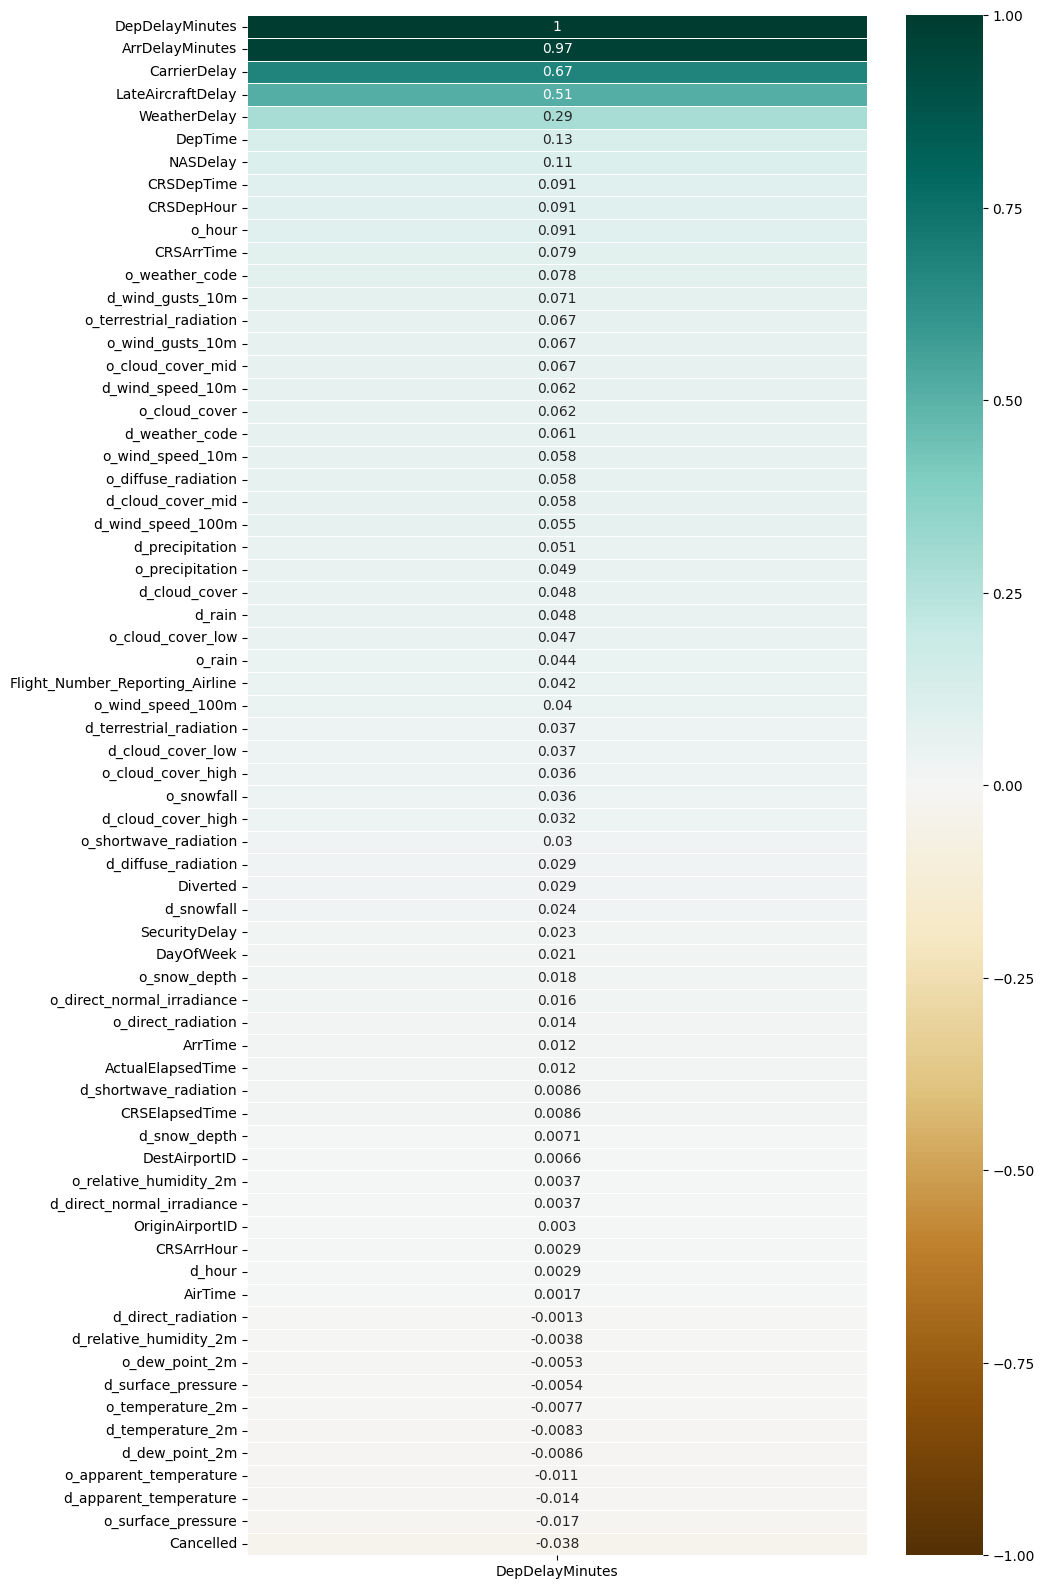

In [32]:
corr_matrix = delay_df.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#[['WeatherDelay']].sort_values(by='WeatherDelay', ascending=False)
plt.figure(figsize=(10, 20))
sns.heatmap(corr_matrix[['DepDelayMinutes']].sort_values(by='DepDelayMinutes', ascending=False), annot=True, cmap='BrBG', linewidths=0.5, vmin=-1, vmax=1);

In [9]:
jfk_delay = delay_df[delay_df['Origin'] == 'LAX']
jfk_delayed = jfk_delay[(jfk_delay['WeatherDelay'] > 0) | (jfk_delay['NASDelay'] > 0)]
jfk_cancelled = jfk_delay[jfk_delay['Cancelled'] == 1]

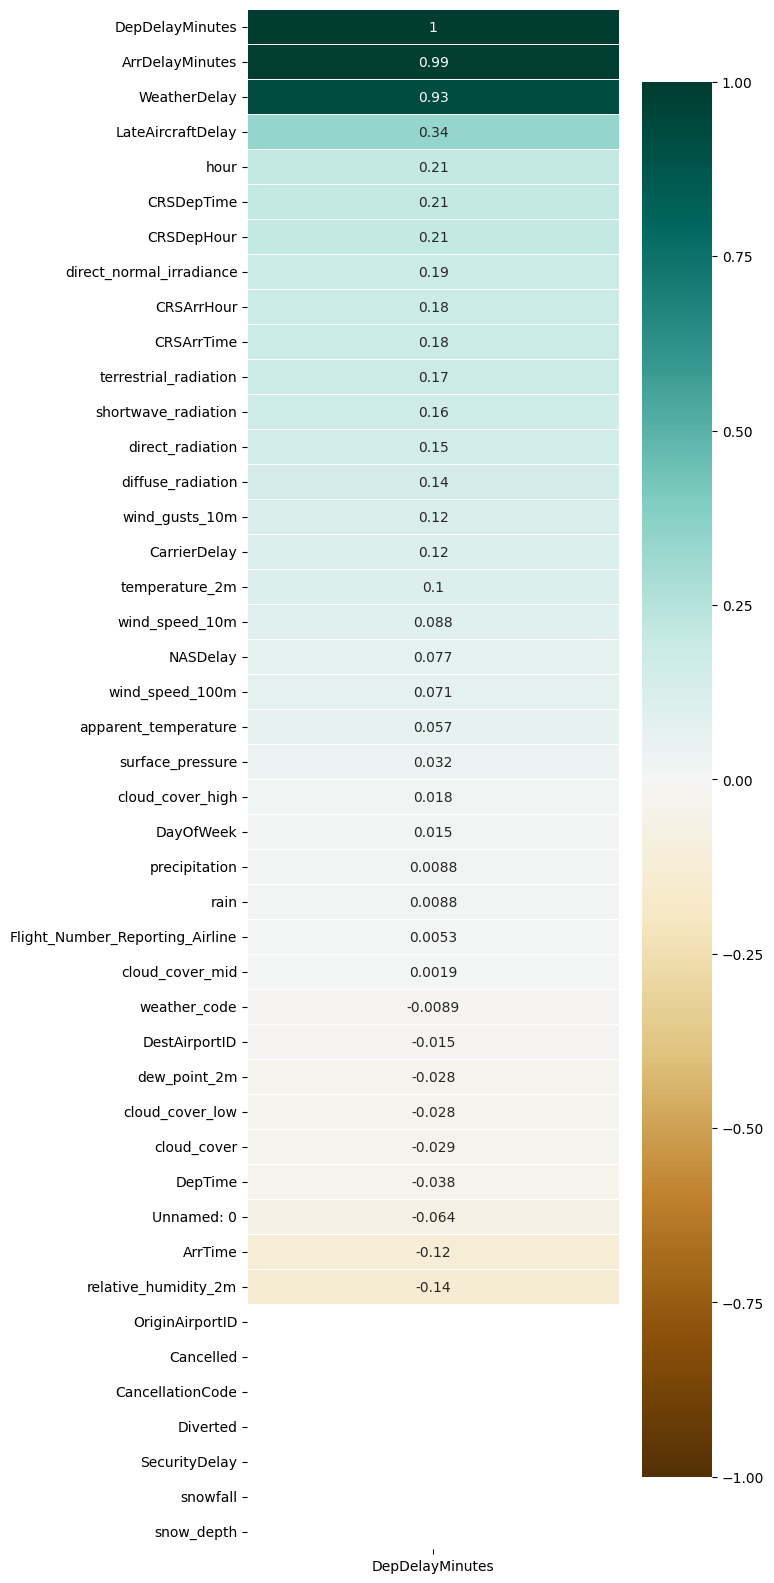

In [10]:
corr_matrix = jfk_delayed.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#[['WeatherDelay']].sort_values(by='WeatherDelay', ascending=False)
plt.figure(figsize=(6, 20))
sns.heatmap(corr_matrix[['DepDelayMinutes']].sort_values(by='DepDelayMinutes', ascending=False), annot=True, cmap='BrBG', linewidths=0.5, vmin=-1, vmax=1);

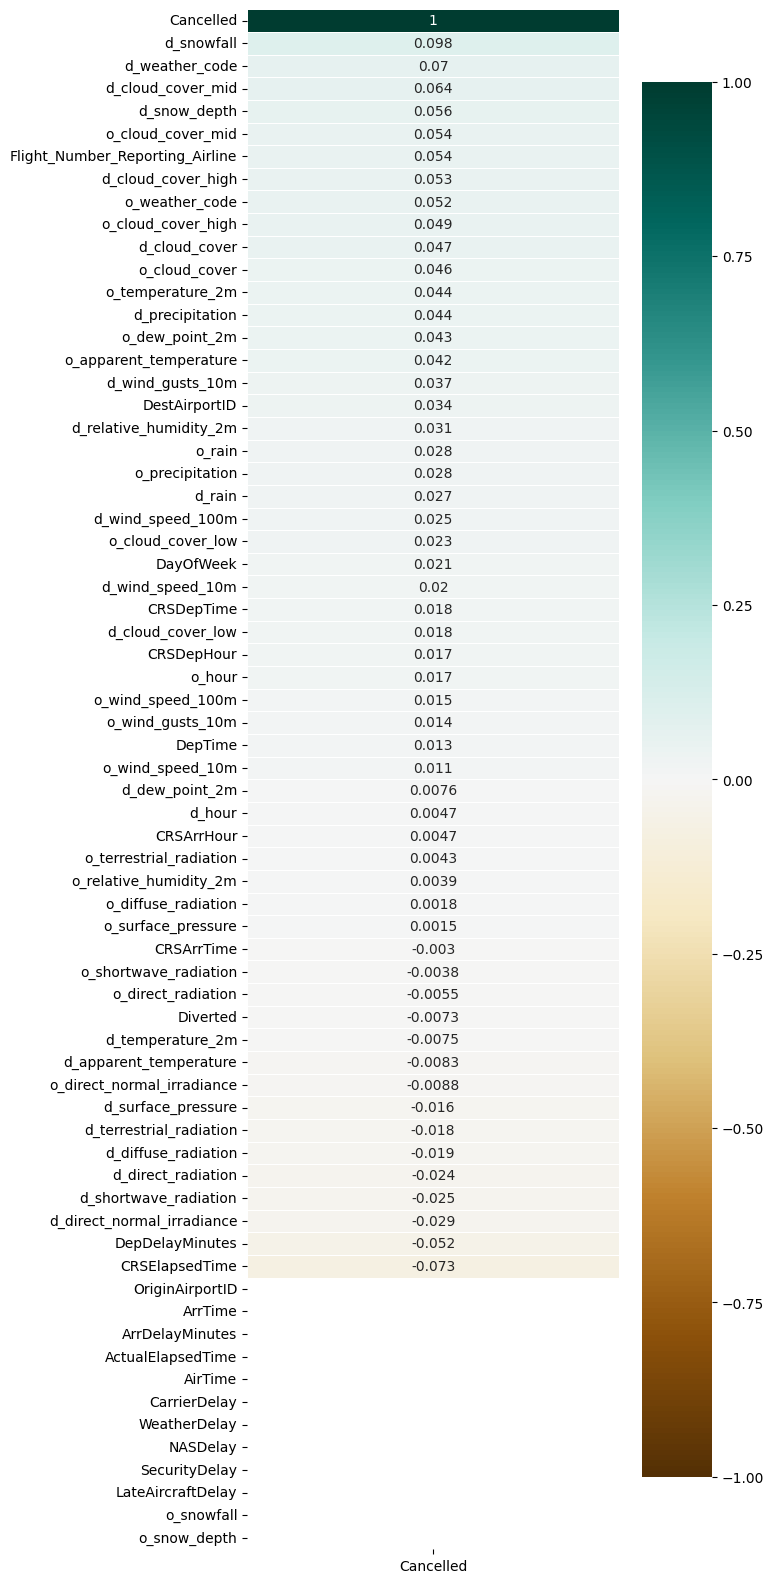

In [43]:
corr_matrix = jfk_delay.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#[['WeatherDelay']].sort_values(by='WeatherDelay', ascending=False)
plt.figure(figsize=(6, 20))
sns.heatmap(corr_matrix[['Cancelled']].sort_values(by='Cancelled', ascending=False), annot=True, cmap='BrBG', linewidths=0.5, vmin=-1, vmax=1);

In [22]:
delay_df.columns

Index(['Unnamed: 0', 'DayOfWeek', 'FlightDate', 'IATA_CODE_Reporting_Airline',
       'Tail_Number', 'Flight_Number_Reporting_Airline', 'OriginAirportID',
       'Origin', 'OriginState', 'DestAirportID', 'Dest', 'DestState',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'CRSArrTime', 'ArrTime',
       'ArrDelayMinutes', 'Cancelled', 'CancellationCode', 'Diverted',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'CRSDepHour', 'CRSArrHour', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid',
       'cloud_cover_high', 'wind_speed_10m', 'wind_speed_100m',
       'wind_gusts_10m', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance',
       'terrestrial_radiation', 'airport', 'day', 'hour'],
      dtype='o

In [14]:
import matplotlib
import numpy as np
np.random.seed(seed=30)

cmap = matplotlib.cm.get_cmap('Spectral')
# Step 2. Create a Pandas series (needed to merge) from a dictionary
# Passing a number betwen 0-1 into cmap will return a color to me
# color_dict = pd.Series({k:cmap(np.random.rand()) for k in df['qSpecies'].unique()})

# # Naming my series so I can merge it below. Only named series can be merged
# color_dict.name = 'color_dict'

/tmp/ipykernel_57595/728444623.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


In [9]:
delay_df.shape

(19127490, 84)

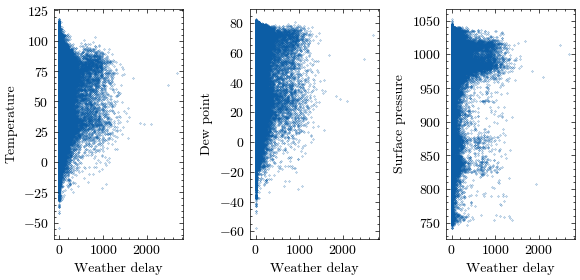

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3))

variables = ['o_temperature_2m', 'o_dew_point_2m', 'o_surface_pressure']
variable_names = ['Temperature', 'Dew point', 'Surface pressure']

for i, (weather_ft, name) in enumerate(zip(variables, variable_names)):
       # 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       # 'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       # 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid',
       # 'cloud_cover_high', 'wind_speed_10m', 'wind_speed_100m',
       # 'wind_gusts_10m', 'shortwave_radiation', 'direct_radiation',
       # 'diffuse_radiation', 'direct_normal_irradiance',
       # 'terrestrial_radiation']:

    delay_df.plot.scatter(x='WeatherDelay', xlabel="Weather delay",
                y=weather_ft,
               s=.05, ax=axes[i], ylabel=name)

plt.tight_layout()
plt.savefig("adverse.png", bbox_inches="tight")

plt.show()
# plt.savefig("scatter.png")

count     114736
unique       354
top          ORD
freq       14169
Name: Origin, dtype: object
Origin
ORD    14169
DFW     7912
ATL     7153
DEN     5309
CLT     4763
IAH     3702
MCO     3390
MSP     2946
BOS     2876
EWR     2844
LGA     2585
MIA     2464
JFK     2411
DTW     2355
DCA     2264
FLL     2154
SEA     1787
SLC     1641
PHL     1561
BWI     1476
TPA     1346
MDW     1289
IAD     1188
LAS     1104
DAL     1098
Name: count, dtype: int64


TypeError: bar() missing 2 required positional arguments: 'x' and 'height'

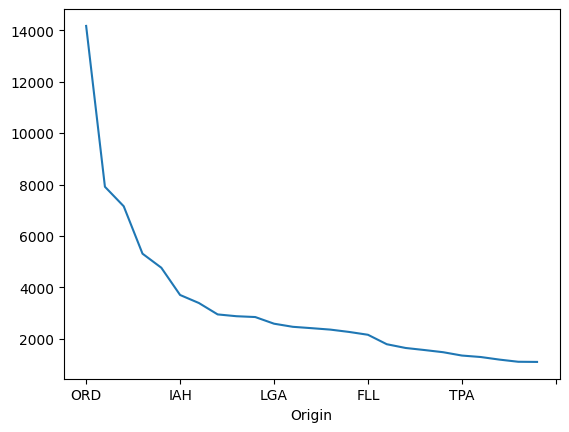

In [61]:
# delay_df['weather_code'].plot(kind='hist', edgecolor='black')
print(delay_df['Origin'].describe())
# hist = delay_df.hist(column="Origin", figsize=(20,20))
count = delay_df['Origin'].value_counts()
count = count[count > 1000]
print(count)
count.plot().bar()

In [41]:
delay_df['delta'] = delay_df['ArrDelayMinutes'] - delay_df['DepDelayMinutes']
print(delay_df['delta'].describe())
print(delay_df['ArrDelayMinutes'].describe())

count    114736.000000
mean         22.020796
std          22.834615
min         -50.000000
25%           6.000000
50%          15.000000
75%          30.000000
max         350.000000
Name: delta, dtype: float64
count    114736.000000
mean        102.291304
std         112.148259
min          15.000000
25%          39.000000
50%          71.000000
75%         125.000000
max        2108.000000
Name: ArrDelayMinutes, dtype: float64
